# Contents
* [Introduction](#Introduction)
  * [FRILL](#FRILL)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Strata](#Strata)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Results](#Results)
  * [Visualization](#Visualization)
  * [Classifier prediction correlations](#Classifier-prediction-correlations)
* [Discussion](#Discussion)

# Introduction

In this notebook, the positive vs. negaative binary classification scenario is considered with the development set of FRILL embeddings.

A test harness is prepared for several models that showed promise in some previous explorations and the results are visualized.

## FRILL

Here are two abstracts to introduce the FRILL embedding:

  [Towards Learning a Universal Non-Semantic Representation of Speech (2020)](#https://doi.org/10.21437/Interspeech.2020-1242)
> The ultimate goal of transfer learning is to reduce labeled data requirements by exploiting a pre-existing embedding model trained for different datasets or tasks. The visual and language communities have established benchmarks to compare embeddings, but the speech community has yet to do so. This paper proposes a benchmark for comparing speech representations on non-semantic tasks, and proposes a representation based on an unsupervised triplet-loss objective. The proposed representation outperforms other representations on the benchmark, and even exceeds state-of-the-art performance on a number of transfer learning tasks. The embedding is trained on a publicly available dataset, and it is tested on a variety of low-resource downstream tasks, including personalization tasks and medical domain. The benchmark, models, and evaluation code are publicly released.

  [FRILL: A Non-Semantic Speech Embedding for Mobile Devices (2021)](#https://arxiv.org/abs/2011.04609)
> Learned speech representations can drastically improve performance on tasks with limited labeled data. However, due to their size and complexity, learned representations have limited utility in mobile settings where run-time performance can be a significant bottleneck. In this work, we propose a class of lightweight non-semantic speech embedding models that run efficiently on mobile devices based on the recently proposed TRILL speech embedding. We combine novel architectural modifications with existing speed-up techniques to create embedding models that are fast enough to run in real-time on a mobile device and exhibit minimal performance degradation on a benchmark of non-semantic speech tasks. One such model (FRILL) is 32x faster on a Pixel 1 smartphone and 40% the size of TRILL, with an average decrease in accuracy of only 2%. To our knowledge, FRILL is the highest-quality non-semantic embedding designed for use on mobile devices. Furthermore, we demonstrate that these representations are useful for mobile health tasks such as non-speech human sounds detection and face-masked speech detection. Our models and code are publicly available.

FRILL is therefore a promising embedding since non-semantic aspects of speech signals is what distinguishes each class for this data. And it's fast!

Moreover, its output representation is a 2,048-element vector irrespective of input size. FRILL enables uniform handling of ragged sequences in an output format that is potentially more compact than spectrograms and MFCCs.

Furthermore, the FRILL representations are not time series, affording the full armamentarium of classifiers.

# Imports and configuration

In [1]:
# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from time import time
from tqdm.notebook import tqdm

# faster pandas/sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from sklearn.metrics import balanced_accuracy_score, f1_score

# cross validator
from sklearn.model_selection import StratifiedGroupKFold

# sklearn classifiers
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# other boosting classifiers
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("ticks")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 3.83 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 200 ms


# Data loading
For this classification task, we only need samples that are labeled positive or negative in valence.

In [5]:
keep_columns = ["id", "speaker_id", "emo", "valence", "lang1", "length"]

data = pd.read_feather(f"{FRILL_FEATHERS_FOLDER}/dev_FRILL.feather").set_index("id")
labels = pd.read_feather(
    f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
).set_index("id")

time: 936 ms


In [6]:
# filter data for positive vs. negative classification
labels = labels.query("valence != 1")  # 0: negative, 1: neutral (dropped), 2: positive
labels.valence = labels.valence // 2  # 0//2=0: negative, 2//2=1: positive
labels.valence.value_counts()
data = data.loc[labels.index, :]

0    9706
1    4444
Name: valence, dtype: int64

time: 352 ms


In [7]:
# uncomment lines to undersample data
# data = data.sample(frac=0.02, random_state=SEED).sort_index()
# labels = labels.loc[data.index, :]
# data = data.head(200)
# labels = labels.head(200)

assert all(data.index == labels.index)
_ = gc_collect()

time: 224 ms


In [8]:
data.head(1)
data.info()
labels.head(1)
labels.info()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
id,,,,,,,,,,,,,,,,,,,,,
0,0.119926,-0.049218,0.039702,0.141101,0.044318,0.049631,0.016178,0.025797,-0.104466,-0.016044,...,-0.226529,-0.091773,0.028184,-0.074794,0.025474,0.046511,-0.002693,-0.017953,-0.146394,-0.06233


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 14150 entries, 0 to 39247
Columns: 2048 entries, 0 to 2047
dtypes: float32(2048)
memory usage: 110.7 MB


,speaker_id,emo,valence,lang1,length
id,,,,,
0,aesdd.1,ang,0,ell,medium


<class 'pandas.core.frame.DataFrame'>
UInt64Index: 14150 entries, 0 to 39247
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   speaker_id  14150 non-null  category
 1   emo         14150 non-null  category
 2   valence     14150 non-null  int8    
 3   lang1       14150 non-null  category
 4   length      14150 non-null  category
dtypes: category(4), int8(1)
memory usage: 237.1 KB
time: 280 ms


# Strata

In this section, strata are set up for the train-test split.

In [9]:
n_splits = 3

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels[["speaker_id", "emo", "valence", "lang1", "length"]]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Pandas Apply: 100%|██████████| 14150/14150 [00:00<00:00, 46494.11it/s]

time: 480 ms


In [10]:
# helper for identifying strata with only i occurences
get_solos = lambda i: np.unique(
    strata.loc[
        strata.isin(
            (strata_counts := strata.value_counts())
            .where(strata_counts == i)
            .dropna()
            .index
        )
    ]
    .sample(frac=1, random_state=SEED)
    .values
)
_ = gc_collect()

time: 159 ms


The next cells combine strata with only 2 occurences with strata with only 1 occurence.

In [11]:
print("before")
only1 = get_solos(1)
print("only 1:", len(only1))
only2 = get_solos(2)
print("only 2:", len(only2))

before
only 1: 347
only 2: 169
time: 24 ms


In [12]:
# replace, 2 + 1 = 3
count = 0
for stratum_pair in zip(only1, only2):
    strata.replace(stratum_pair, f"stratum_group_{count}", inplace=True)
    count += 1
print()

print("after")
# one of these should print 0
only1 = get_solos(1)
print("only 1:", len(only1))
only2 = get_solos(2)
print("only 2:", len(only2))


after
only 1: 178
only 2: 0
time: 482 ms


The next cell merges remaining strata with only 1 occurence in triplets.

In [13]:
interval = len(only1) // n_splits
for stratum_triplet in zip(
    *[only1[interval * i : interval * (i + 1)] for i in range(n_splits)]
):
    strata.replace(stratum_triplet, f"stratum_group_{count}", inplace=True)
    count += 1
only1 = get_solos(1)
print("only 1:", len(only1))
only2 = get_solos(2)
print("only 2:", len(only2))

only 1: 1
only 2: 0
time: 191 ms


There is one stratum remaining with only 1 occurence. We will randomly choose another stratum with n_splits occurences and merge these.

In [14]:
strata.replace(
    [
        (strata_counts := strata.value_counts())
        .where(strata_counts == n_splits)
        .dropna()
        .sample(n=1, random_state=SEED)
        .index[0]
    ]
    + only1.tolist(),
    f"stratum_group_{count}",
    inplace=True,
)
assert get_solos(2).size == get_solos(1).size == 0
assert len(data) == len(strata)

time: 32 ms


In [15]:
del count
del interval
del get_solos
del only1
del only2
_ = gc_collect()

time: 184 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of three-fold cross validation such that the results may be easily cast to a `pandas` dataframe.

In [16]:
metrics = (
    "avg_cv_balanced_accuracy",
    "avg_cv_f1",
    "avg_cv_fit_time",
    "avg_cv_predict_time",
)

# to be cast to pd.DataFrame
results = {key: [] for key in {"model_name", "case", *metrics}}

AvgScores = namedtuple("AvgScores", metrics)


def store_result(case: str, model_name: str, avg_scores: AvgScores) -> None:
    "Appends a model's score and fit/predict times to the results."
    for attribute, value in {
        ("model_name", model_name),
        ("case", case),
        ("avg_cv_balanced_accuracy", avg_scores.avg_cv_balanced_accuracy),
        ("avg_cv_f1", avg_scores.avg_cv_f1),
        ("avg_cv_fit_time", avg_scores.avg_cv_fit_time),
        ("avg_cv_predict_time", avg_scores.avg_cv_predict_time),
    }:
        results[attribute].append(value)


_ = gc_collect()

time: 167 ms


# Models

Thanks to FRILL, we may now use the gamut of classifiers provided by `sklearn`. Boosting methods outside of `sklearn` include `LightGBM` and `XGBoost`.

For the most part, the default settings of each classifier are used. Where possible, the seed is set and all available cores are used. Each classifier is wrapped in a lambda function to ensure a brand new model is initialized each time the function is called.

In [17]:
models = {
    "AdaBoostClassifier": lambda: AdaBoostClassifier(random_state=SEED),
    "LogisticRegression": lambda: LogisticRegression(random_state=SEED, n_jobs=-1),
    "MLPClassifier": lambda: MLPClassifier(random_state=SEED),
    "RandomForestClassifier": lambda: RandomForestClassifier(
        n_jobs=-1, random_state=SEED
    ),
    "RidgeClassifier": lambda: RidgeClassifier(random_state=SEED),
    "SGDClassifier": lambda: SGDClassifier(n_jobs=-1, random_state=SEED),
    "SVC": lambda: SVC(random_state=SEED, probability=True),
    "LGBMClassifier": lambda: LGBMClassifier(
        boosting_type="rf",
        random_state=SEED,
        n_jobs=-1,
        subsample=0.75,
        subsample_freq=1,
    ),
    "XGBClassifier": lambda: XGBClassifier(
        eval_metric="mlogloss", seed=SEED, use_label_encoder=False
    ),
    "DummyClassifier": lambda: DummyClassifier(random_state=SEED),
}
_ = gc_collect()

time: 151 ms


We also define a structure to track the predictions of each model within each fold so that their correlations may be assessed.

In [18]:
predictions = {fold: {model: None for model in models} for fold in {1, 2, 3}}
_ = gc_collect()

time: 167 ms


# Test harness

This section defines the test harness for evaluating models.

In [19]:
def evaluate_model(
    model_base: str, case: str, track_fold_time: bool = False
) -> AvgScores:
    """Evaluate a model with three-fold stratified grouped cross validation."""

    fit_times, predict_times, balanced_accuracy, f1 = [], [], [], []
    fold_num = 0
    for train_idxs, test_idxs in StratifiedGroupKFold(
        n_splits=n_splits, shuffle=True, random_state=SEED
    ).split(X=data, y=strata, groups=labels.speaker_id):
        fold_num += 1
        if track_fold_time:
            fold_begin = time()

        # define X
        X_test = data.iloc[test_idxs].reset_index(drop=True)
        X_train = data.iloc[train_idxs].reset_index(drop=True)

        if "ternary" in case:
            # define y
            y_train = labels.iloc[train_idxs].loc[:, "valence"]
            y_test = labels.iloc[test_idxs].loc[:, "valence"]
            # initialize multiclass model
            params = {"estimator": models[model_base](), "n_jobs": -1}
            model = (
                OneVsRestClassifier(**params)
                if case == "ternary_ovr"
                else OneVsOneClassifier(**params)
            )
            del params
        else:
            # initialize binary model
            model = models[model_base]()
            if case == "posneg":
                # define y, pre-filtered in this notebook for posneg
                y_train = labels.iloc[train_idxs].loc[:, "valence"]
                y_test = labels.iloc[test_idxs].loc[:, "valence"]
            else:
                # define y
                label = case[:3]
                y_train = labels.iloc[train_idxs].loc[:, label]
                y_test = labels.iloc[test_idxs].loc[:, label]
                del label

        # reset y indices
        y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        fit_times.append(end - begin)

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        predict_times.append(end - begin)
        predictions[fold_num][model_base] = predicted

        # score
        score_params = {"y_true": y_test, "y_pred": predicted}
        balanced_accuracy.append(balanced_accuracy_score(**score_params))
        f1.append(f1_score(**score_params, average="weighted"))

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num} completed in {time() - fold_begin:.2f} s"
            )

        # free some memory
        del begin
        del end
        del model
        del predicted
        del score_params
        del X_test
        del X_train
        del y_test
        del y_train
        _ = gc_collect()

    return AvgScores(
        *[np.mean(_) for _ in (balanced_accuracy, f1, fit_times, predict_times)]
    )


_ = gc_collect()

time: 151 ms


# Results

We collect the results in this section.

In [20]:
case = "posneg"
for model in tqdm(models):
    _ = gc_collect()
    store_result(
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case, track_fold_time=True),
    )
    print(f"stored {model}")

  0%|          | 0/10 [00:00<?, ?it/s]

AdaBoostClassifier fold 1 completed in 94.44 s
AdaBoostClassifier fold 2 completed in 152.17 s
AdaBoostClassifier fold 3 completed in 155.51 s
stored AdaBoostClassifier
LogisticRegression fold 1 completed in 4.13 s
LogisticRegression fold 2 completed in 5.25 s
LogisticRegression fold 3 completed in 6.11 s
stored LogisticRegression
MLPClassifier fold 1 completed in 53.93 s
MLPClassifier fold 2 completed in 69.46 s
MLPClassifier fold 3 completed in 66.78 s
stored MLPClassifier
RandomForestClassifier fold 1 completed in 6.26 s
RandomForestClassifier fold 2 completed in 8.41 s
RandomForestClassifier fold 3 completed in 9.35 s
stored RandomForestClassifier
RidgeClassifier fold 1 completed in 1.77 s
RidgeClassifier fold 2 completed in 2.10 s
RidgeClassifier fold 3 completed in 2.25 s
stored RidgeClassifier
SGDClassifier fold 1 completed in 3.10 s
SGDClassifier fold 2 completed in 3.64 s
SGDClassifier fold 3 completed in 3.66 s
stored SGDClassifier
SVC fold 1 completed in 44.73 s
SVC fold 2 c

## Visualization

In this section, we create several visualizations to display the results.

In [21]:
metric_names = {
    "avg_cv_balanced_accuracy": "balanced accuracy",
    "avg_cv_f1": "F1 score",
    "avg_cv_fit_time": "fit time",
    "avg_cv_predict_time": "predict time",
}

results_df = (
    pd.DataFrame(results).sort_values(by=["case", "model_name"]).reset_index(drop=True)
)
results_df

,avg_cv_fit_time,avg_cv_f1,model_name,case,avg_cv_balanced_accuracy,avg_cv_predict_time
0,133.392608,0.636046,AdaBoostClassifier,posneg,0.556955,0.303051
1,0.000000,0.559660,DummyClassifier,posneg,0.500000,0.000000
2,42.768745,0.591134,LGBMClassifier,posneg,0.514839,0.309221
3,4.668652,0.672443,LogisticRegression,posneg,0.598916,0.034693
4,62.965085,0.684544,MLPClassifier,posneg,0.611885,0.068381
5,7.414936,0.567027,RandomForestClassifier,posneg,0.503902,0.226161
6,1.676181,0.671608,RidgeClassifier,posneg,0.596723,0.036695
7,2.910732,0.668787,SGDClassifier,posneg,0.594952,0.191468
8,52.573740,0.662937,SVC,posneg,0.583148,3.582212
9,356.997881,0.639480,XGBClassifier,posneg,0.557123,0.262901


time: 31.3 ms


In [22]:
def plot_metric(metric: str) -> None:
    """Draw a barplot by classifier."""
    _df = results_df.sort_values(by=metric, ascending="time" in metric)
    if "time" in metric:
        _df = _df.loc[~_df.model_name.isin({"DummyClassifier", "StackingClassifier"})]
    _df.model_name = _df.model_name.str.replace("Classifier", "")
    g = sns.catplot(
        data=_df, kind="bar", x="model_name", y=metric, palette="colorblind", alpha=0.8,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    plt.xlabel("")
    plt.xticks(rotation=-30)
    plt.ylabel("")
    plt.suptitle(metric_names[metric])
    plt.show()


_ = gc_collect()

time: 141 ms


When plotting fit/predict times, the dummy classifier is omitted since it is always the fastest.

  0%|          | 0/4 [00:00<?, ?it/s]

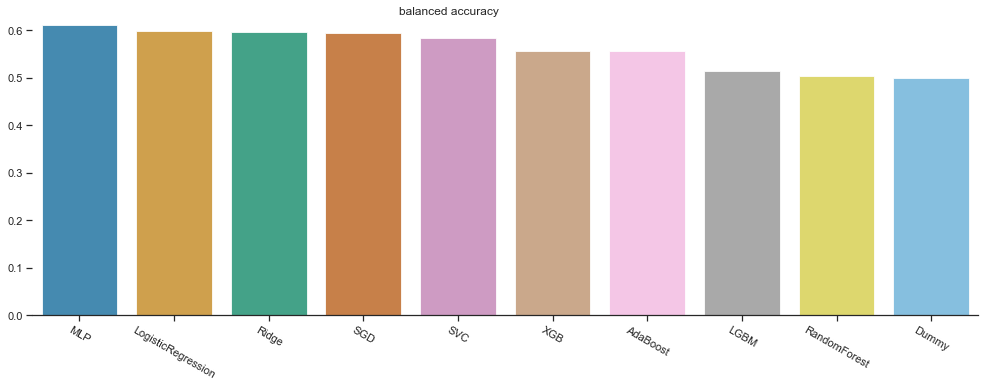

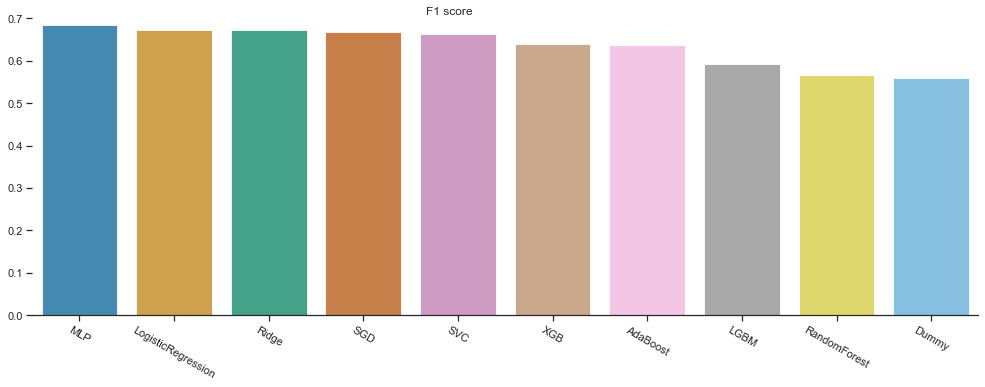

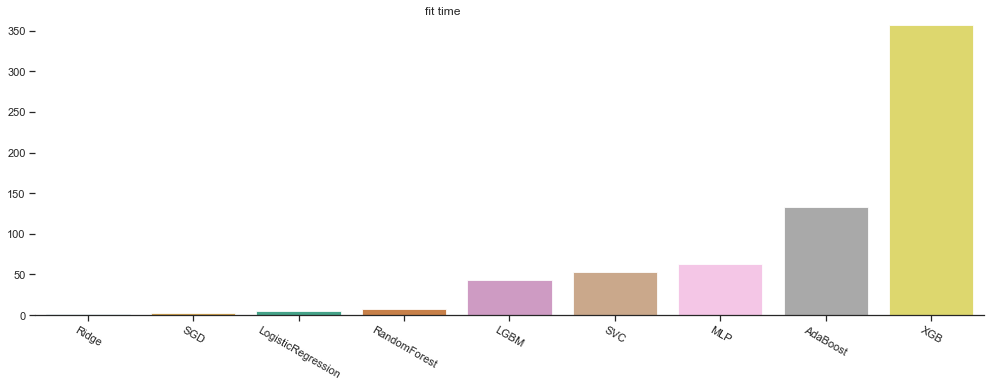

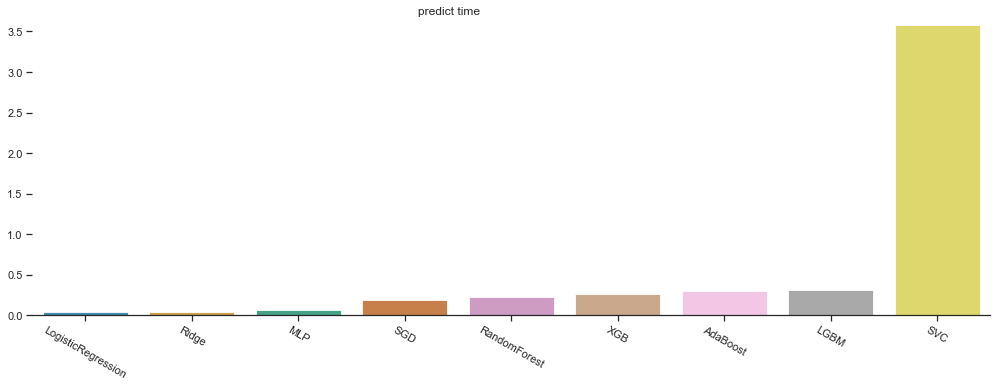

time: 1.83 s


In [23]:
for metric in tqdm(metrics):
    plot_metric(metric)
    _ = gc_collect()

In [24]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/explore_neutral_binary_results.csv")

time: 12 ms


## Classifier prediction correlation

In this section, we assess the correlation between each model's predictions. Performant and uncorrelated models are ideal for a potential stacked classifier.

Text(0.5, 0.98, 'Fold #1')

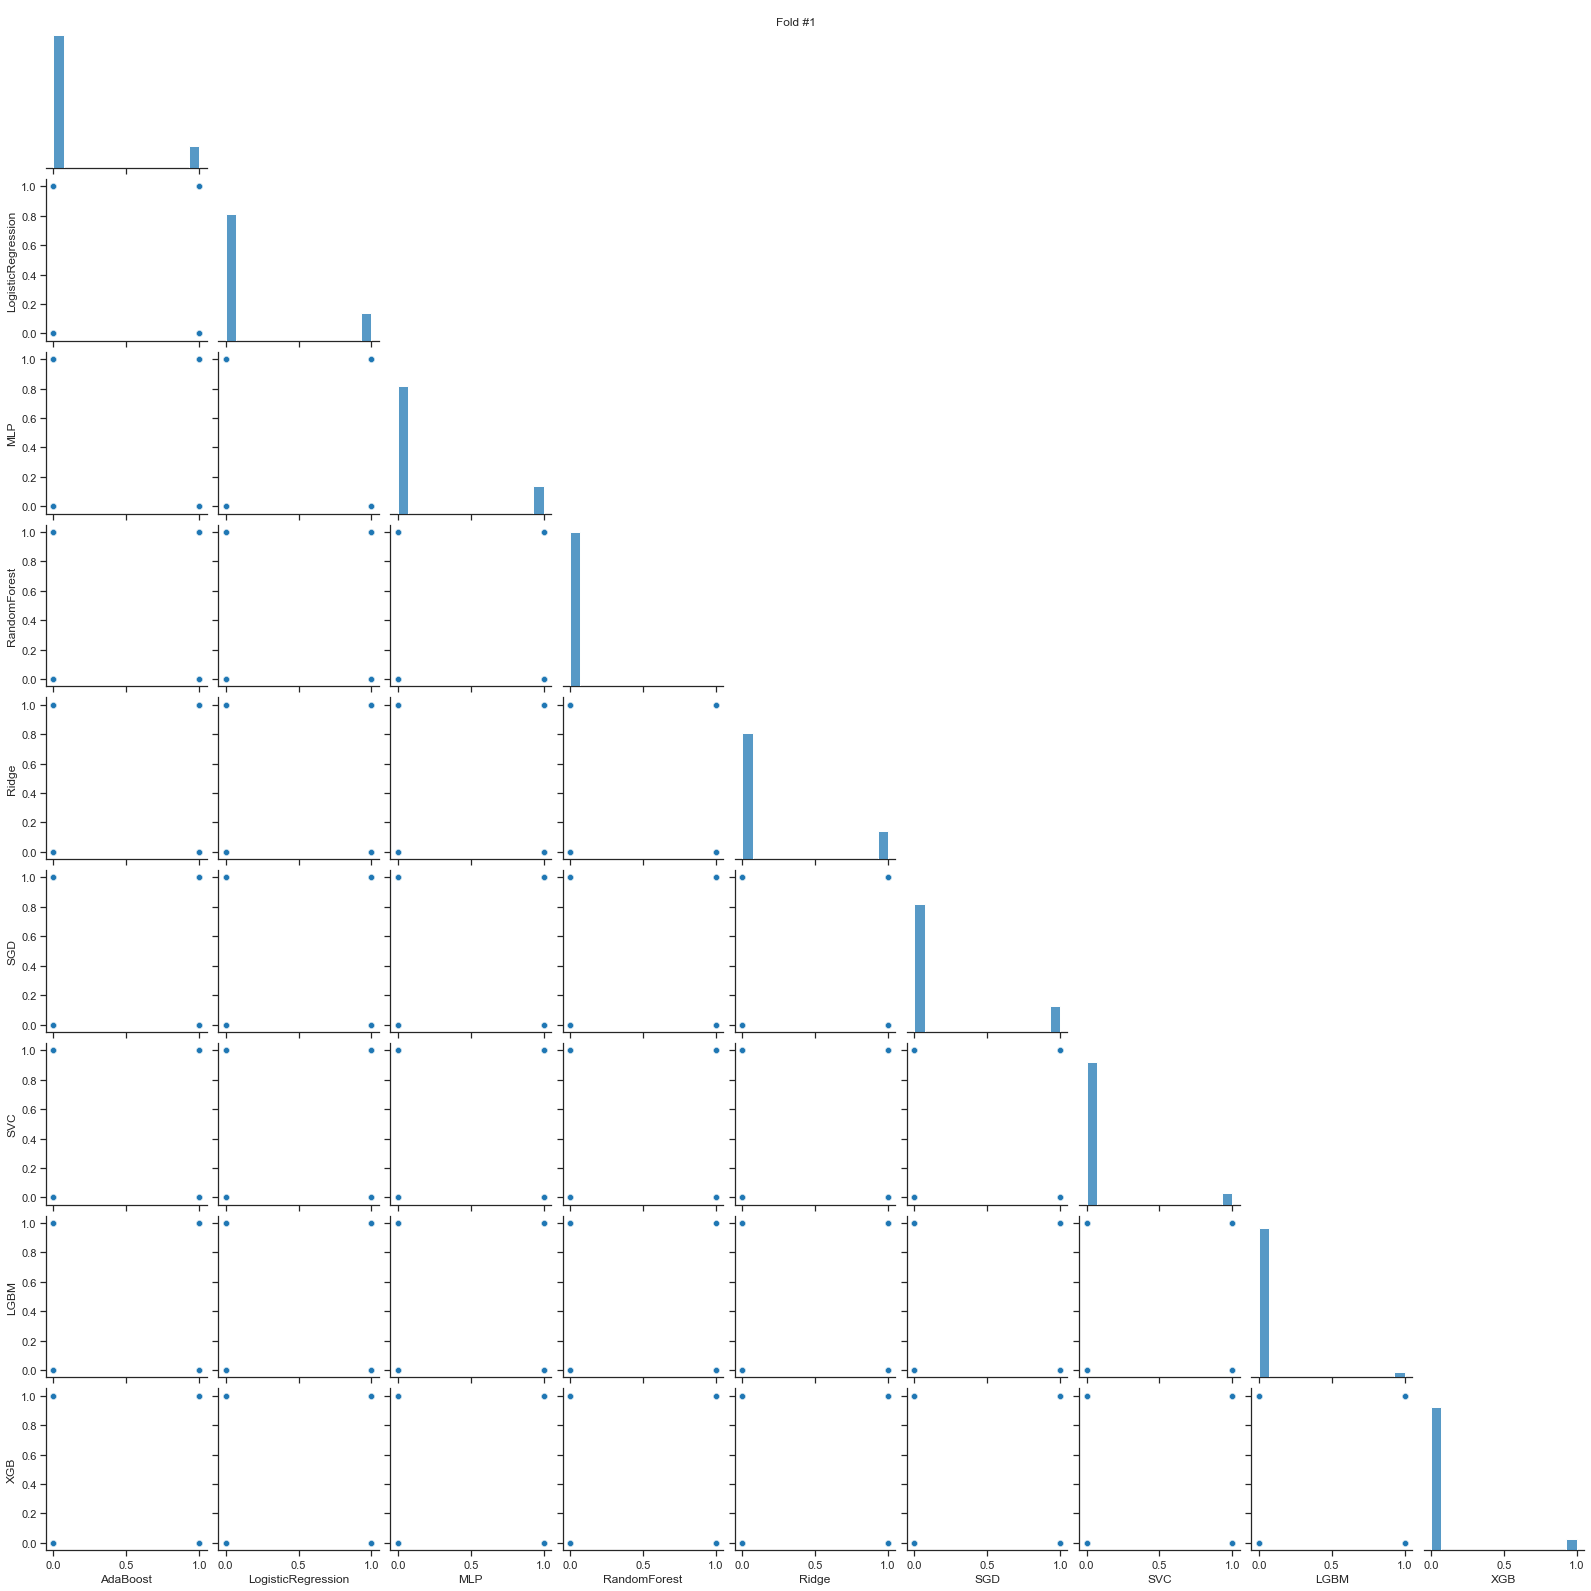

Text(0.5, 0.98, 'Fold #1')

<AxesSubplot:>

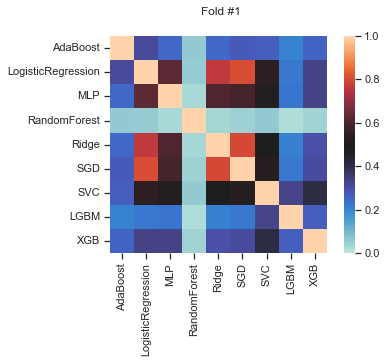

Text(0.5, 0.98, 'Fold #2')

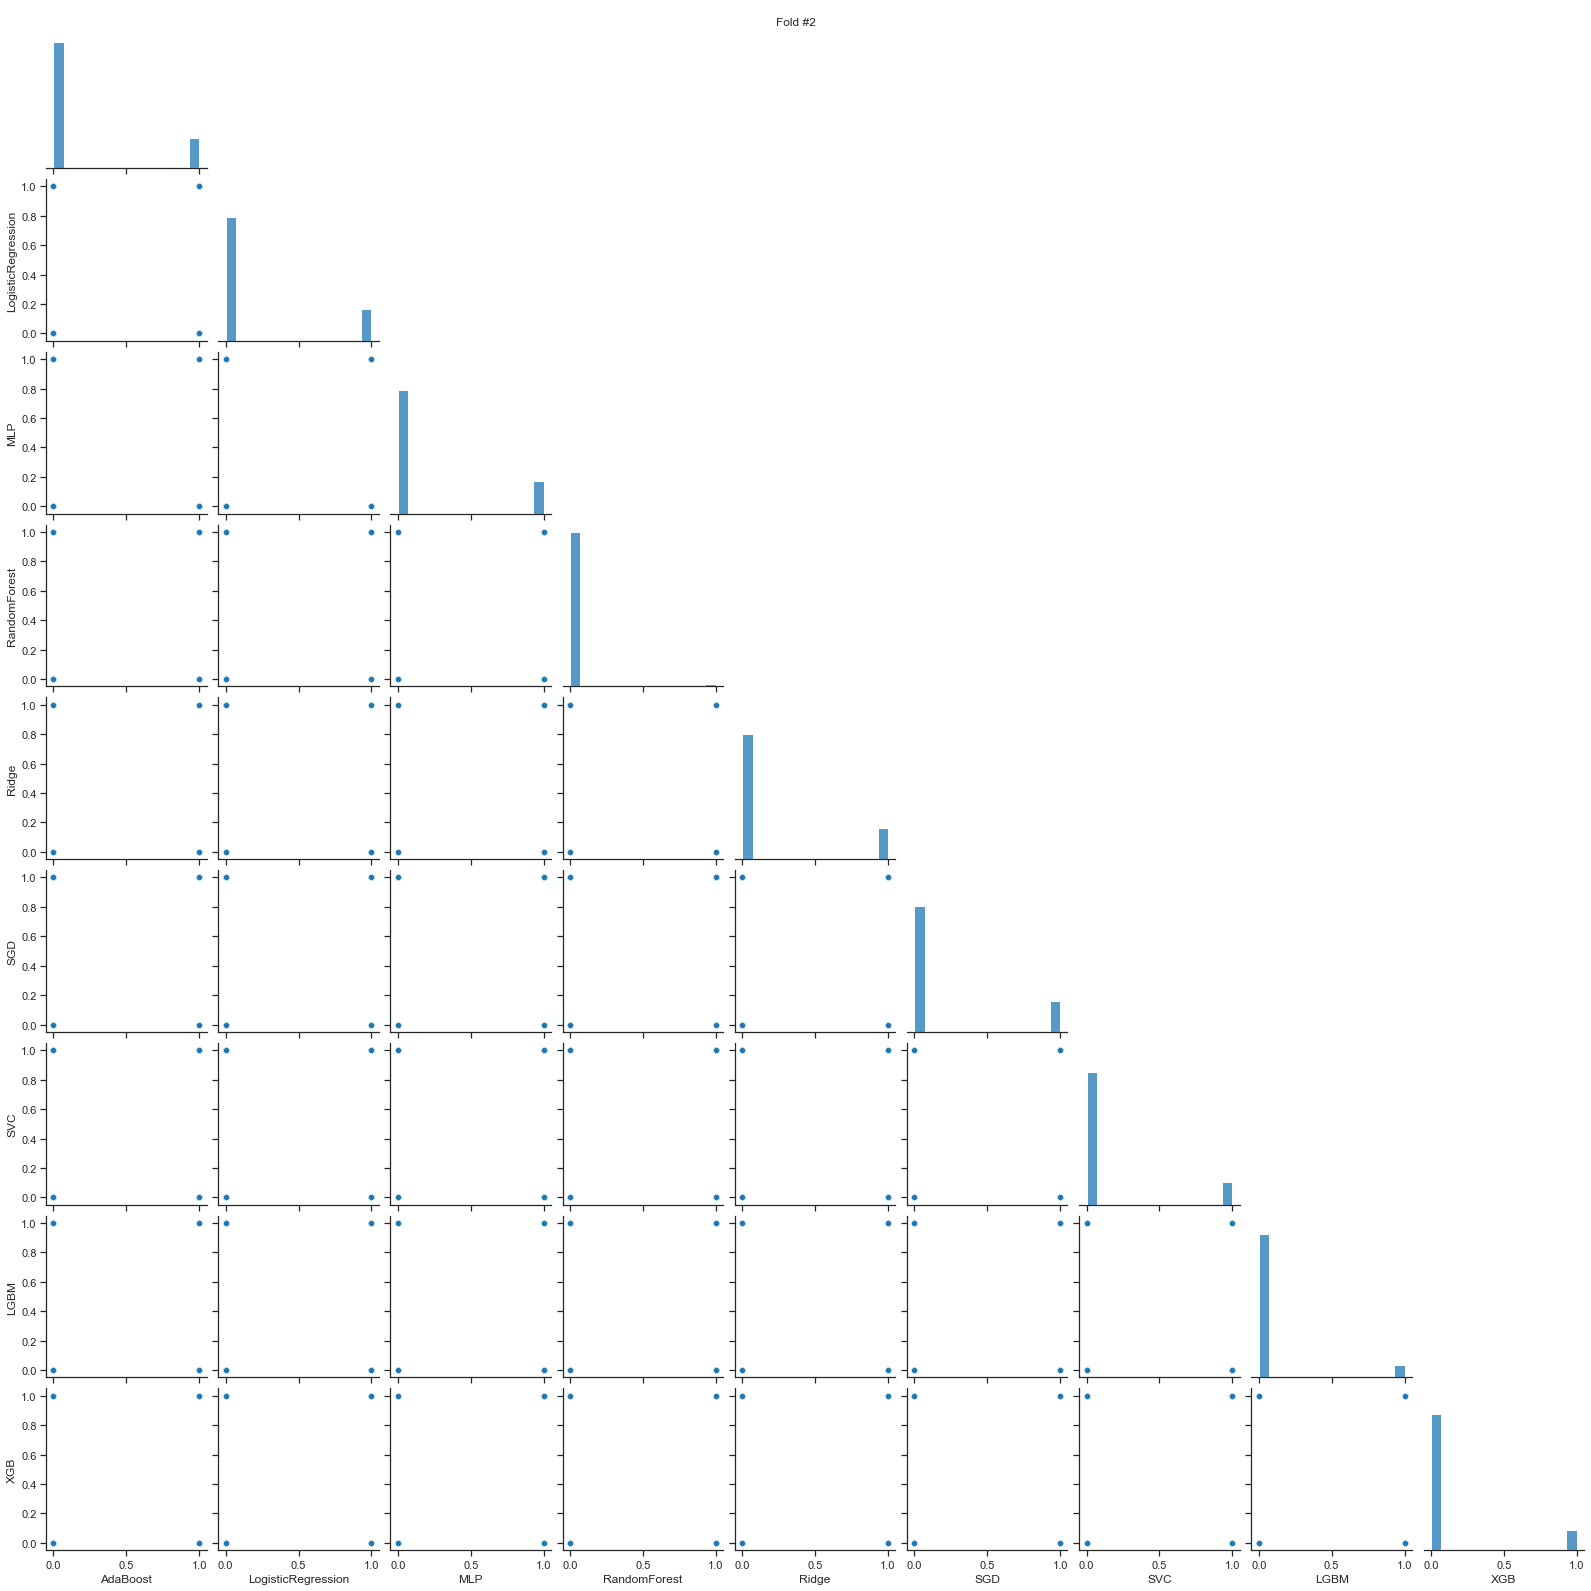

Text(0.5, 0.98, 'Fold #2')

<AxesSubplot:>

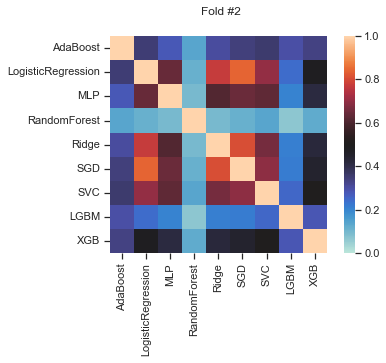

Text(0.5, 0.98, 'Fold #3')

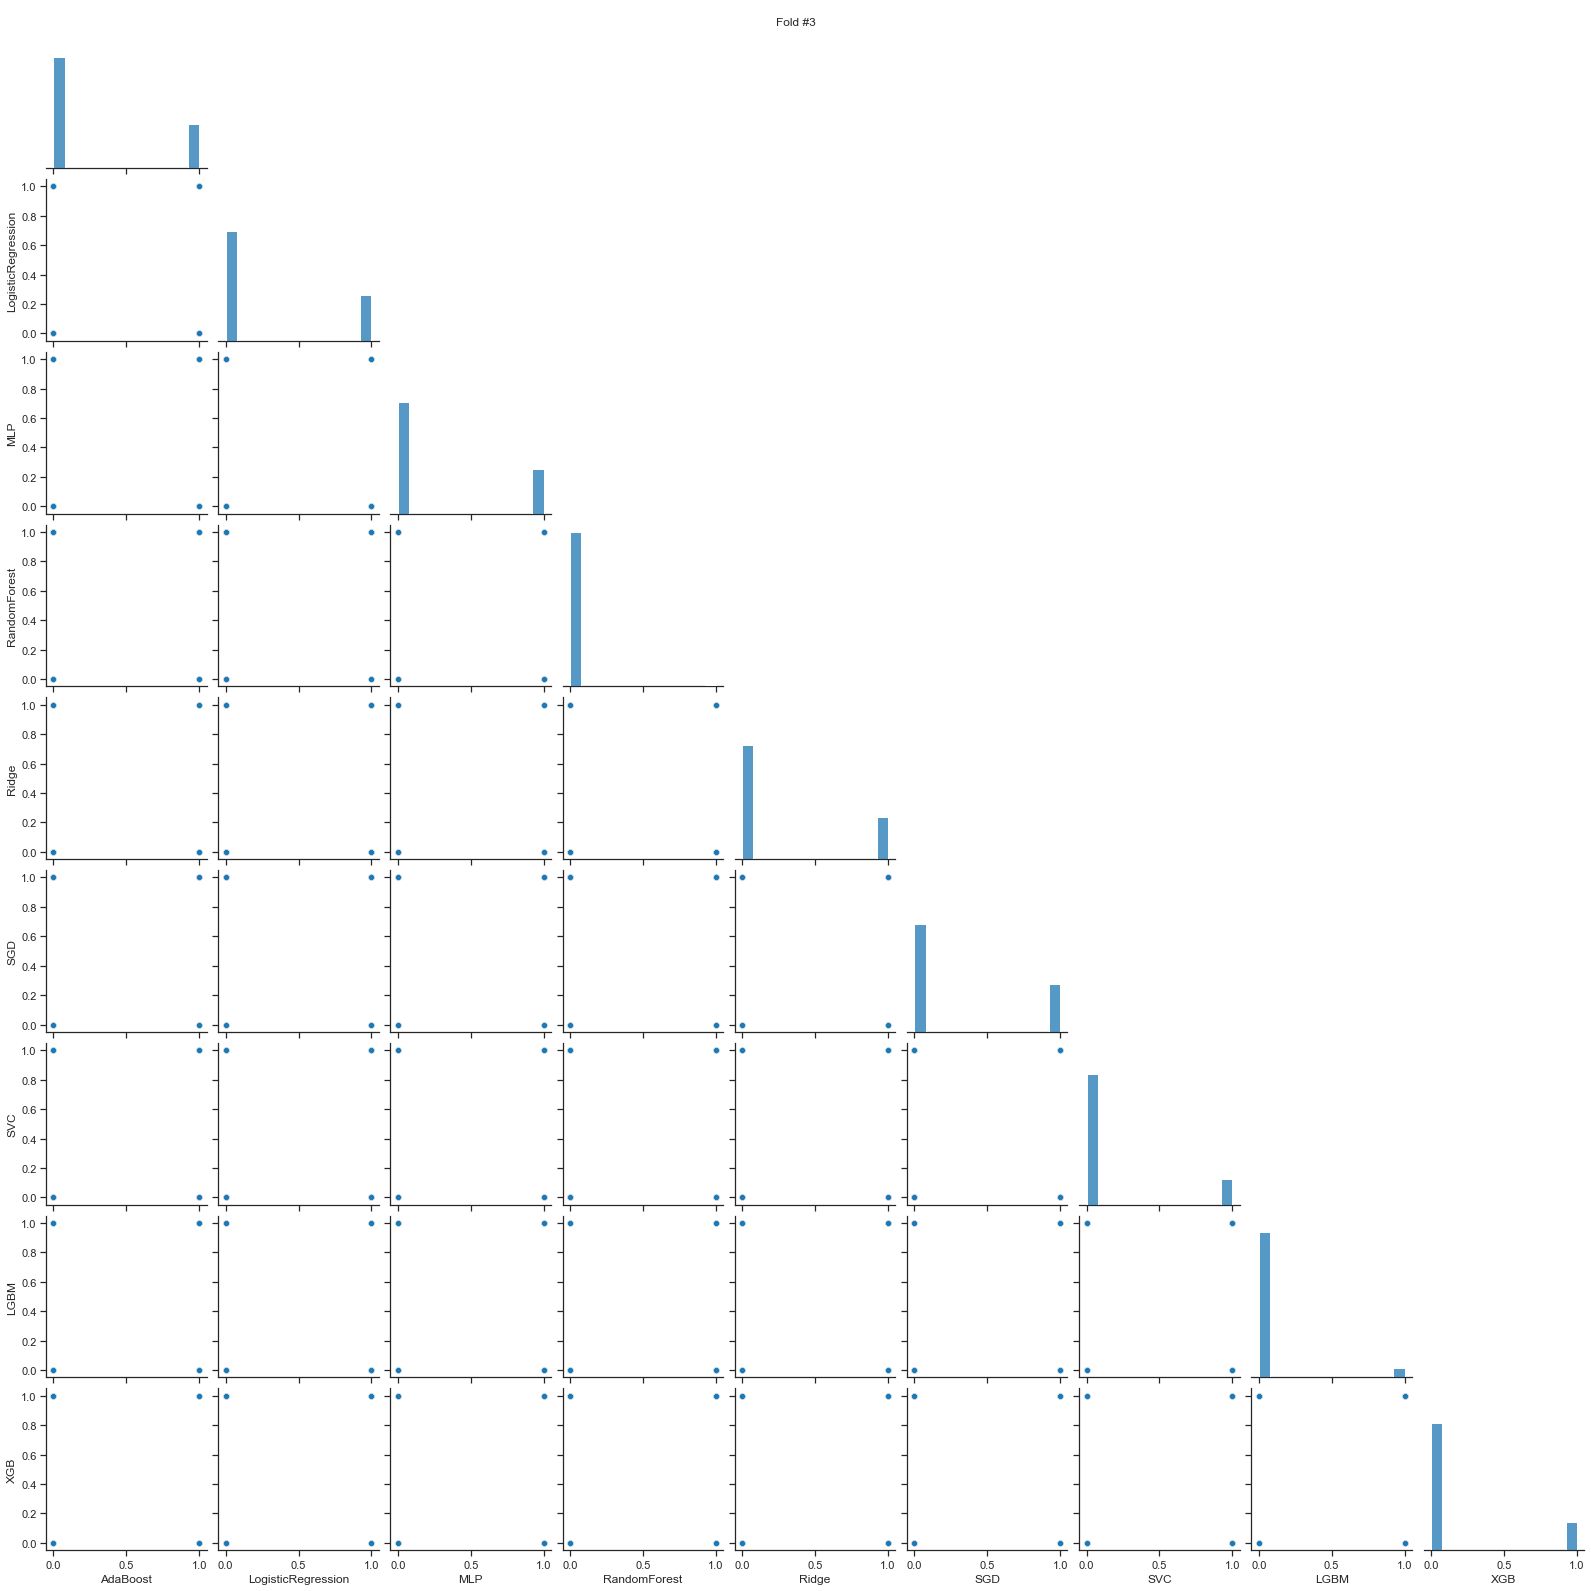

Text(0.5, 0.98, 'Fold #3')

<AxesSubplot:>

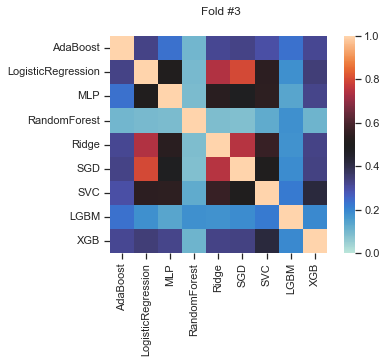

time: 36.4 s


In [25]:
for fold in predictions:
    title = f"Fold #{fold}"
    sns.pairplot(
        data=(
            _df := pd.DataFrame(predictions[fold])
            .drop(columns="DummyClassifier")
            .rename(columns=lambda _: _.replace("Classifier", ""))
            .astype(np.uint8)
        ),
        palette="colorblind",
        corner=True,
    )
    plt.suptitle(title)
    plt.show()

    plt.suptitle(title)
    sns.heatmap(_df.corr(), cmap="icefire", square=True, vmin=0, vmax=1)
    plt.show()

    del _df
    del title
    _ = gc_collect()

# Discussion

These scores are middling, but all models outperformed the dummy.

The vanilla MLP from sklearn is one of the top contenders. This leaves open the possibility of pursuing a pure deep learning approach. I imagine a straightforward dense net with one or two hidden layers could be tuned.

The heatmaps reveal similar prediction correlations between folds. Although the tree-based methods aren't as performant as the others, they are the most uncorrelated, whereas the most performant models also have the most correlated predictions. Maybe an ensemble of just the tree-based methods (meta-ensemble?) would be appropriate and this assembly could be subsequently ensembled with the more performant classifiers.

The pair plots were uninformative due to overplotting, but they illustrate class imbalance. A better measure of correlation may be Cramer's V or Theil's U, both of which are more suitable for categorical-categorical correlations.

[^top](#Contents)